INSURANCE PREMIUM PREDICTION





In [ ]:
import pandas as pd
import numpy as np
import statsmodels
import warnings
warnings.filterwarnings('ignore')

import plotly.express as px
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split

from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import AdaBoostRegressor
import xgboost as xgb

from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
import pickle

In [ ]:
!pip install azureml
!pip install azureml-core
!pip install azureml-train
!pip install azureml-Dataset-runtime

In [ ]:
df = pd.read_csv("/content/insurance.csv")



In [ ]:
df

,age,sex,bmi,children,smoker,region,expenses
0,19,female,27.9,0,yes,southwest,16884.92
1,18,male,33.8,1,no,southeast,1725.55
2,28,male,33.0,3,no,southeast,4449.46
3,33,male,22.7,0,no,northwest,21984.47
4,32,male,28.9,0,no,northwest,3866.86
...,...,...,...,...,...,...,...
1333,50,male,31.0,3,no,northwest,10600.55
1334,18,female,31.9,0,no,northeast,2205.98
1335,18,female,36.9,0,no,southeast,1629.83
1336,21,female,25.8,0,no,southwest,2007.95


"We've got a dataset containing 1338 rows and 7 columns, each row providing details about individual customers. Our primary goal is to predict the 'expenses' column value based on the information contained in the other columns. Initially, we'll train our model on the historical data. Once it's trained, we can use it to estimate expenses for new customers by simply inputting their age, sex, BMI, number of children, smoking habits, and region.

Now, let's take a look at the data types assigned to each column.


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   expenses  1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB


In [ ]:
df.describe()

,age,bmi,children,expenses
count,1338.000000,1338.000000,1338.000000,1338.000000
mean,39.207025,30.665471,1.094918,13270.422414
std,14.049960,6.098382,1.205493,12110.011240
min,18.000000,16.000000,0.000000,1121.870000
25%,27.000000,26.300000,0.000000,4740.287500
50%,39.000000,30.400000,1.000000,9382.030000
75%,51.000000,34.700000,2.000000,16639.915000
max,64.000000,53.100000,5.000000,63770.430000


The numerical columns have reasonable value ranges; fortunately, there are no negative ages, so extensive data cleaning or correction may not be necessary. However, it's worth noting that the "expenses" column appears to be significantly skewed, as evidenced by the fact that the median 50th percentile is considerably lower than the maximum value.

Regarding the "expenses" column, there appears to be a significant difference between the 75th percentile and the maximum expense value, indicating the presence of outliers. These outliers will need to be addressed.

As for the "bmi" column, the range of values between the 75th percentile and the maximum BMI value is relatively small, suggesting that there might be some outliers here as well.

Interestingly, nearly 50 percent of the customers have only one child based on the available data.

In [ ]:
fig = px.histogram(df,
                   x='age',
                   marginal='box',
                   nbins=47,
                   title='Distribution of Age')
fig.update_layout(bargap=0.1)
fig.show()


The dataset shows a fairly uniform distribution of ages, with approximately 20-30 customers at each age, except for ages 18 and 19, which have significantly more than twice as many customers compared to other ages in the dataset.

In [ ]:
fig = px.histogram(df,
                    x='bmi',
                    marginal='box',
                    color_discrete_sequence=['red'],
                    title='Distribustion of BMI (Body Mass Index)')

fig.update_layout(bargap=0.1)
fig.show()

The values are centered around 30

In [ ]:
fig = px.histogram(df,
                    x='expenses',
                    marginal='box',
                    color='smoker',
                    color_discrete_sequence=['green', 'orange'],
                    title="Annual Medical Expenses")

fig.update_layout(bargap=0.1)
fig.show()

The majority of customers have annual medical expenses under 10,000 dollars. However, a small fraction of customers have considerably higher medical expenses, potentially attributed to accidents, major illnesses, and genetic diseases. This distribution pattern follows a "power law."

There is a substantial disparity in medical expenses between smokers and non-smokers. The median medical expense for non-smokers is around 7,300 dollars, whereas for smokers, the median is close to 35,000 dollars. This suggests that smoking habits significantly impact medical costs.

In [ ]:
fig = px.histogram(df,
                    x="expenses",
                    marginal="box",
                    color="sex",
                    color_discrete_sequence=["blue", "purple"],
                    title="Annual Medical Expenses by Sex")

fig.update_layout(bargap=0.1)
fig.show()

There is a significant difference in expenses between male and female. While the median for male and female is almost same but upper fence for male is 40k, the upper fence for female is close to 28k.

In [ ]:
fig = px.histogram(df,
                    x="expenses",
                    marginal="box",
                    color="region",
                    color_discrete_sequence=["grey", "orange", "green","violet"],
                    title="Annual Medical Expenses by Region")

fig.update_layout(bargap=0.1)
fig.show()

We make some obervation from the above graph

There is significant difference in expenses for southeast, southwest, northeast and northwest. While the median for southwest is 8798 , the median for southeast is close to 9294, the median for northwest is 8965 and median for northeast is 10.05k.
And the upper fence for southwest is close to 26k, upper fence for southeast is close to 42k, upper fence for northwest is close to 4230kk and the upper fence for northeast is close to 34k.

In [ ]:
px.histogram(df, x="smoker", color="sex", title="Smoker")

From the above graph we make some observations.

It appears that 20% of the customers have reported they smoking.
We can also see that smoking appears a more common habit among males.

In [ ]:
px.histogram(df, x="smoker", color="children", title="Smoker Vs Children")

Having looked at individual columns, we can now visualize the relationship between "expenses" (the value we wish to predict) and other columns.

Age and Charges
Let's visualize the relationship between "age" and "expenses" using a scatter plot. Each point in the scatter plot represents one customer. We'll also use values in the "smoker" column to color the points.

In [ ]:
fig = px.scatter(df,
                x="age",
                y="expenses",
                color="smoker",
                opacity=0.8,
                hover_data=["sex"],
                width=800,
                height=500,
                title="Age vs Expenses")

fig.update_traces(marker_size=5)
fig.show()

In [ ]:
fig = px.scatter(df,
                x="bmi",
                y="expenses",
                color="smoker",
                hover_data=['sex'],
                opacity=0.8,
                width=800,
                height=500,
                title="BMI Vs Expenses")

fig.update_traces(marker_size=5)
fig.show()

Text(0.5, 1.0, 'Correlation Matrix')

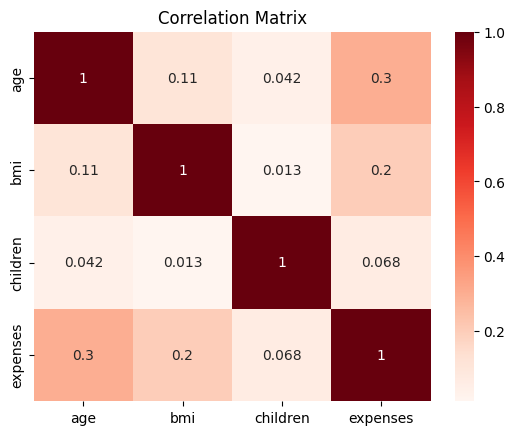

In [ ]:
sns.heatmap(df.corr(), cmap='Reds', annot=True)
plt.title('Correlation Matrix')

In [ ]:
smoker_values = {'no': 0, 'yes': 1}
smoker_numeric = df.smoker.map(smoker_values)
df.expenses.corr(smoker_numeric)

0.7872514298985541

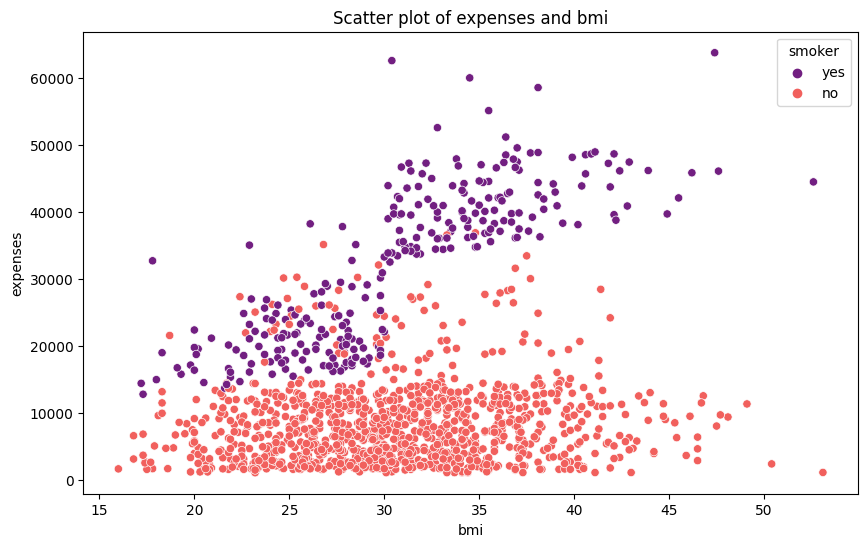

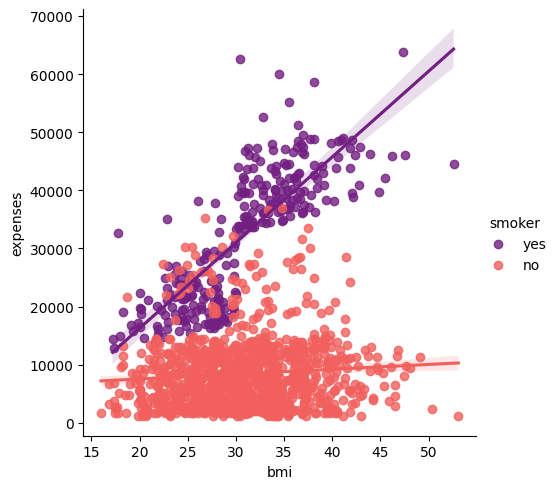

In [ ]:
plt.figure(figsize=(10,6))
ax = sns.scatterplot(x='bmi',y='expenses',data=df,palette='magma',hue='smoker')
ax.set_title('Scatter plot of expenses and bmi')

sns.lmplot(x="bmi", y="expenses", hue="smoker", data=df, palette = 'magma')

In [ ]:
#one hot encoding
df=pd.get_dummies(df)

In [ ]:
X = df.drop(['expenses'], axis=1)
y = df['expenses']

In [ ]:
# Splitting the dataset for training and testing the model
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
linear_reg = LinearRegression()
linear_reg.fit(X_train, y_train)

y_pred = linear_reg.predict(X_test)

linear_reg_mse = mean_squared_error(y_test, y_pred)
linear_reg_rmse = mean_squared_error(y_test, y_pred, squared=False)
linear_reg_r2_score = r2_score(y_test, y_pred)

# Evaluation Metrics
print("The Mean Squared Error using Linear Regression :{}".format(linear_reg_mse))
print(('The Root Mean Squared Error using Linear Regression :{}'.format(linear_reg_rmse)))
print(('The r2_score using Linear Regression :{}'.format(linear_reg_r2_score)))

The Mean Squared Error using Linear Regression :33600065.355077825
The Root Mean Squared Error using Linear Regression :5796.556335884076
The r2_score using Linear Regression :0.7835726930039906


In [ ]:
decision_tree = DecisionTreeRegressor(max_depth=4, min_samples_split=4,random_state=42)
decision_tree.fit(X_train, y_train)
# Predicting the model
y_pred1 = decision_tree.predict(X_test)
# Evaluation Metrics
decision_tree_mse = mean_squared_error(y_test, y_pred)
decision_tree_rmse = mean_squared_error(y_test, y_pred1, squared=False)
decision_tree_r2_score = r2_score(y_test, y_pred1)

print("The Mean Squared Error using Decision Tree Regressor : {}".format(decision_tree_mse))
print("The Root Mean Squared Error using Decision Tree Regressor : {}".format(decision_tree_rmse))
print("The r2_score using Decision Tree Regressor : {}".format(decision_tree_r2_score))

The Mean Squared Error using Decision Tree Regressor : 0.22928504860620744
The Root Mean Squared Error using Decision Tree Regressor : 0.3792450133636133
The r2_score using Decision Tree Regressor : 0.8642386719351669


In [ ]:
random_forest_reg=RandomForestRegressor(n_estimators=30, max_depth=4, min_samples_split=5,random_state=42)
random_forest_reg.fit(X_train, y_train)

# Predicting the model
y_pred2 = random_forest_reg.predict(X_test)

# Evaluation Metrics
random_forest_mse = mean_squared_error(y_test, y_pred2)
random_forest_rmse = mean_squared_error(y_test, y_pred2, squared=False)
random_forest_r2_score = r2_score(y_test, y_pred2)

print("The Mean Squared Error using Random Forest Regressor : {}".format(random_forest_mse))
print("The Root Mean Squared Error using Random Forest Regressor : {}".format(random_forest_rmse))
print("The r2_score Error using Random Forest Regressor : {}".format(random_forest_r2_score))

The Mean Squared Error using Random Forest Regressor : 0.13928610348582507
The Root Mean Squared Error using Random Forest Regressor : 0.37321053506811014
The r2_score Error using Random Forest Regressor : 0.8685247186301336


In [ ]:
gradient_boosting_reg=GradientBoostingRegressor()
gradient_boosting_reg.fit(X_train, y_train)

# Predicting the model
y_pred3 = gradient_boosting_reg.predict(X_test)

# Evaluation Metrics
gradient_boosting_mse = mean_squared_error(y_test, y_pred3)
gradient_boosting_rmse = mean_squared_error(y_test, y_pred3, squared=False)
gradient_boosting_r2_score = r2_score(y_test, y_pred3)

print("The Mean Squared Error using Gradient Boosting Regressor : {}".format(gradient_boosting_mse))
print("The Root Mean Squared Error using Gradient Boosting Regressor : {}".format(gradient_boosting_rmse))
print("The r2_sccore using Gradient Boosting Regressor : {}".format(gradient_boosting_r2_score))

The Mean Squared Error using Gradient Boosting Regressor : 0.12824934750936423
The Root Mean Squared Error using Gradient Boosting Regressor : 0.35811918059406456
The r2_sccore using Gradient Boosting Regressor : 0.8789425604758093


In [ ]:
xgb_reg = xgb.XGBRegressor()
xgb_reg.fit(X_train, y_train)

# Predicting the moodel
y_pred5 = xgb_reg.predict(X_test)

# Evaluation Metrics
xgb_reg_mse = mean_squared_error(y_test, y_pred5)
xgb_reg_rmse = mean_squared_error(y_test, y_pred5, squared=False)
xgb_reg_r2_score = r2_score(y_test, y_pred5)

print("The mean square error using XGBoost is {}".format(xgb_reg_mse))
print("The root mean_squared error using XGBoost is {}".format(xgb_reg_rmse))
print("The r2 score using XGBoost is {}".format(xgb_reg_r2_score))

The mean square error using XGBoost is 0.16743490504069433
The root mean_squared error using XGBoost is 0.4091881047155383
The r2 score using XGBoost is 0.8419544326358269


In [ ]:
models = pd.DataFrame({
    'Model' : ['Linear Regression', 'Decision Tree', 'Random Forest',
               'Gradient Boosting',  'XGBoost'],
    'RMSE' : [linear_reg_rmse, decision_tree_rmse, random_forest_rmse,
            gradient_boosting_rmse,  xgb_reg_rmse],
    'r2_score' : [linear_reg_r2_score, decision_tree_r2_score, random_forest_r2_score,
    gradient_boosting_r2_score,  xgb_reg_r2_score]
})

models.sort_values(by='RMSE', ascending=True)

,Model,RMSE,r2_score
3,Gradient Boosting,0.358119,0.878943
2,Random Forest,0.373211,0.868525
1,Decision Tree,0.379245,0.864239
4,XGBoost,0.409188,0.841954
0,Linear Regression,0.478837,0.783573


In [ ]:
train_enc_cols = X.columns

In [ ]:
train_enc_cols

Index(['age', 'bmi', 'children', 'sex_female', 'sex_male', 'smoker_no',
       'smoker_yes', 'region_northeast', 'region_northwest',
       'region_southeast', 'region_southwest'],
      dtype='object')

In [ ]:
model = GradientBoostingRegressor()

# Fit the model with your training data and target values
trained_model = model.fit(X_train, y_train)

In [ ]:
import joblib
model_file = '/content/model.pkl'

joblib.dump(value=[train_enc_cols, trained_model],
            filename=model_file)

['/content/model.pkl']

In [ ]:
from azureml.core import Workspace, Dataset, Experiment

In [ ]:
print('Accessing the workspace....')
ws                = Workspace.from_config("/content/config.json")

Accessing the workspace....
Performing interactive authentication. Please follow the instructions on the terminal.


Interactive authentication successfully completed.


In [ ]:
print('Accessing/Creating the experiment...')
experiment = Experiment(workspace=ws, name='Pred')

Accessing/Creating the experiment...


In [ ]:

print('Start Experiment using Start Logging method...')
new_run = experiment.start_logging()

#New run in Azureml


Start Experiment using Start Logging method...


In [ ]:
new_run.complete()

In [ ]:
from azureml.core import Model

In [ ]:
model = Model.register(workspace=ws,model_name='pre_model',
                       model_path='/content/model.pkl',
                       model_framework=Model.Framework.SCIKITLEARN,
                       model_framework_version='1',
                       description='regression model for diabetes prediction')

Registering model pre_model
